Index(['Year', 'Economy Label', 'Access to Finance', 'ICT',
       'Industry Activity', 'Overall Index', 'Research and Development',
       'Skills'],
      dtype='object')
Random Forest Classification Report
              precision    recall  f1-score   support

    Advanced       0.95      0.97      0.96       232
    Beginner       0.96      0.94      0.95       232
Intermediate       0.91      0.91      0.91       232

    accuracy                           0.94       696
   macro avg       0.94      0.94      0.94       696
weighted avg       0.94      0.94      0.94       696



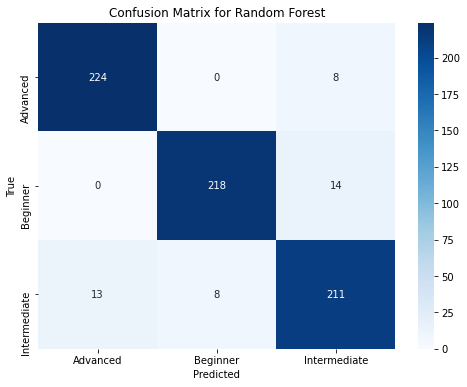

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import lime
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Define the file path
file_path = r"C:\Users\ZAPANTA\Downloads\AIM-MIB2025A-AIProject\AIM-MIB2025A-AIProject\FINAL Project\Global Innovation Index (2008-2021).csv"

# Load the dataset
gii_data = pd.read_csv(file_path)

# Strip any leading or trailing spaces from the column names
gii_data.columns = gii_data.columns.str.strip()

# Pivot the data to get one row per country per year with all indices as columns
gii_pivot = gii_data.pivot_table(index=['Year', 'Economy Label'], columns='Category Label', values='Index').reset_index()

# Rename columns to ensure they match expected feature names
gii_pivot.columns.name = None  # Remove the name from columns MultiIndex
gii_pivot = gii_pivot.rename(columns={'Overall index': 'Overall Index', 'ICT': 'ICT', 'Skills': 'Skills', 'Research and Development': 'Research and Development', 'Industry activity': 'Industry Activity', 'Access to finance': 'Access to Finance'})

# Display the column names to ensure they are correct
print(gii_pivot.columns)

# Convert the 'Overall Index' column to numeric, coercing errors to NaN
gii_pivot['Overall Index'] = pd.to_numeric(gii_pivot['Overall Index'], errors='coerce')

# Drop rows with NaN values in 'Overall Index' after conversion
gii_pivot.dropna(subset=['Overall Index'], inplace=True)

# Convert 'Overall Index' to categories: 'Beginner', 'Intermediate', 'Advanced'
thresholds = gii_pivot['Overall Index'].quantile([0.3333, 0.6666])
beginner_threshold = thresholds.iloc[0]
intermediate_threshold = thresholds.iloc[1]

def categorize_overall_index(index):
    if index <= beginner_threshold:
        return 'Beginner'
    elif index <= intermediate_threshold:
        return 'Intermediate'
    else:
        return 'Advanced'

gii_pivot['Overall Index Category'] = gii_pivot['Overall Index'].apply(categorize_overall_index)

# Define the feature columns and target column
features = ['Year', 'ICT', 'Skills', 'Research and Development', 'Industry Activity', 'Access to Finance']
target = 'Overall Index Category'

# Define features and target
feature_data = gii_pivot[features].copy()
target_data = gii_pivot[target].copy()

# Define the preprocessing pipeline
numerical_features = ['Year', 'ICT', 'Skills', 'Research and Development', 'Industry Activity', 'Access to Finance']
categorical_features = []

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.3, random_state=42, stratify=target_data)

# Define and train the Random Forest model
random_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

random_forest_model.fit(X_train, y_train)

# Predict and evaluate the Random Forest model
y_pred_rf = random_forest_model.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf)
print("Random Forest Classification Report")
print(rf_report)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=random_forest_model.named_steps['classifier'].classes_, yticklabels=random_forest_model.named_steps['classifier'].classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

# Transform the training data using the preprocessor
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# LIME explanation
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed,
    feature_names=numerical_features,
    class_names=random_forest_model.named_steps['classifier'].classes_,
    mode='classification'
)

instance_idx = 0
instance = X_test_transformed[instance_idx].reshape(1, -1)
exp = explainer_lime.explain_instance(
    data_row=instance[0],
    predict_fn=random_forest_model.predict_proba
)
exp.show_in_notebook(show_table=True)

# SHAP explanation
explainer_shap = shap.TreeExplainer(random_forest_model.named_steps['classifier'])
shap_values = explainer_shap.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, plot_type='bar')

instance_idx = 0
instance = X_test_transformed[instance_idx]
shap.initjs()
shap.force_plot(explainer_shap.expected_value, shap_values[instance_idx], instance)